<a href="https://colab.research.google.com/github/jeffblackadar/CRANE-CCAD-maps/blob/main/class_tile_tiff_shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tile_tiff

## Problem:
Some geotiffs are too large to be processed. For example, Azure Cognitive Services can process up to a 4mb tiff on the free tier or 50mb on the paid tier. The exmaple tiff is 90 mb.

## Function:
This program takes a large geotiff and divides it into smaller geotiff tiles.

## Inputs:

## Outputs:



In [2]:
!pip install rasterio
!pip install geopandas

In [9]:
import rasterio
import rasterio.plot
import gdal
import osr
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np
import gdalnumeric
import cv2
import os

class Tile_tiff:

    # class attribute
    tiff_to_tile_path = "" # the source tiff to be split into tiles
    tt_tile_path = "/content/" # the path to where the tiles are saved   

    # varables for gdal    
    tt_gdal_dataset = ""
    tt_srs = ""
    tt_cols = 0
    tt_rows = 0

    # varables for rasterio
    tt_raterio_dataset = 0
    tt_crs = 0
    tt_crs_int = 0
    tt_left_min_x = 0
    tt_bottom_min_y = 0
    tt_right_max_x = 0
    tt_top_max_y = 0
    tt_coords = 0
    tt_pixel_size_x = 0
    tt_pixel_size_y = 0

    # set this for tile size
    tt_tile_pixel_width = 1024
    tt_tile_pixel_height = 768

    # set this for overlap
    tt_tile_pixel_width_overlap = 0 # 200
    tt_tile_pixel_height_overlap = 0 # 100

    tt_tile_matrix = []
    # gdal
    tt_gdal_driver = ""
    tt_gdal_dataset = ""
    tt_gdal_dataset_band = ""
    tt_gdal_transform = ""
    tt_gdal_data = ""

    def create_tile_matrix(self):
        self.tt_tile_matrix = []
        number_tiles_wide = int(self.tt_cols/(self.tt_tile_pixel_width - self.tt_tile_pixel_width_overlap))+1
        number_tiles_high = int(self.tt_rows/(self.tt_tile_pixel_height - self.tt_tile_pixel_height_overlap))+1
        print("create_tile_matrix", number_tiles_wide,number_tiles_high)    
        # rows
        for tif_rows in range(0, number_tiles_high):
            # columns
            for tif_cols in range(0, number_tiles_wide):

                lrx = 0 + ((self.tt_tile_pixel_width - self.tt_tile_pixel_width_overlap) * tif_cols)  # self.tt_left_min_x
                lry = 0 + ((self.tt_tile_pixel_height - self.tt_tile_pixel_height_overlap) * tif_rows)  # self.tt_bottom_min_y

                ulx = lrx + self.tt_tile_pixel_width
                uly = lry + self.tt_tile_pixel_height
                if(lrx>self.tt_cols):
                    lrx=self.tt_cols
                
                if(lry>self.tt_rows):
                    lry=self.tt_rows
                
                if(ulx>self.tt_cols):
                    ulx=self.tt_cols
                
                if(uly>self.tt_rows):
                    uly=self.tt_rows
                
                self.tt_tile_matrix.append([[lrx, lry], [ulx, uly], [tif_cols,tif_rows]])

        return(self.tt_tile_matrix)
    
    def create_tile_files(self):
        self.tt_boundary_polys = gpd.GeoDataFrame()
        self.tt_boundary_polys['geometry'] = None
        self.tt_boundary_polys.crs = ("EPSG:" + str(self.tt_crs_int))
        self.tt_boundary_polys.geometry = self.tt_boundary_polys.geometry.to_crs(crs=self.tt_crs_int)
        self.tt_boundary_polys.to_crs(crs=self.tt_crs_int)
        self.tt_boundary_polys = self.tt_boundary_polys.to_crs(epsg=self.tt_crs_int)
        for tile in self.tt_tile_matrix:
            minx = tile[0][0]
            maxx = tile[1][0]
            miny = tile[0][1]
            maxy = tile[1][1]

            tilex = "00"+str(tile[2][0])
            tilex = tilex[-2:]
            tiley = "00"+str(tile[2][1])
            tiley = tiley[-2:]

            self.tt_gdal_data = self.tt_gdal_dataset_band.ReadAsArray(minx, miny, maxx-minx, maxy-miny)

            output_file_name_base = "r" + tiley + "c" + tilex 
            output_file_name_tiff = output_file_name_base + ".tif"
            output_file_path = os.path.join(self.tt_tile_path,output_file_name_tiff)

            self.tile_dst_ds = self.tt_gdal_driver.Create(output_file_path,
                                           maxx-minx,
                                           maxy-miny,
                                           1,
                                           gdal.GDT_Byte)
            
            this_tile_x_min = self.tt_left_min_x + (minx*self.tt_pixel_size_x)
            this_tile_y_min = self.tt_top_max_y - (miny*self.tt_pixel_size_y)
            this_tile_x_max = self.tt_left_min_x + (maxx*self.tt_pixel_size_x)
            this_tile_y_max = self.tt_top_max_y - (maxy*self.tt_pixel_size_y)

            this_tile_transform = (this_tile_x_min, self.tt_gdal_transform[1], self.tt_gdal_transform[2], this_tile_y_min, self.tt_gdal_transform[4], self.tt_gdal_transform[5])
            self.tile_dst_ds.GetRasterBand(1).WriteArray(self.tt_gdal_data)
            self.tile_dst_ds.SetProjection( self.tt_srs.ExportToWkt() )
            self.tile_dst_ds.SetGeoTransform(this_tile_transform)
            tif_metadata = {
                        "minX": str(minx), "maxX": str(maxx),
                        "minY": str(miny), "maxY": str(maxy)
            }
            self.tile_dst_ds.SetMetadata(tif_metadata)
            self.tile_dst_ds = None

            coords = [(this_tile_x_min, this_tile_y_min), (this_tile_x_max, this_tile_y_min), (this_tile_x_max, this_tile_y_max), (this_tile_x_min, this_tile_y_max)]
            poly = Polygon(coords)
            new_tp_row = {'id':output_file_name_base, 'geometry':poly}
            self.tt_boundary_polys = self.tt_boundary_polys.append(new_tp_row, ignore_index=True)     

        self.tt_boundary_polys.to_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))

    def __init__(self,tiff_to_tile_path, tt_tile_path = "/content/"):
        self.tiff_to_tile_path = tiff_to_tile_path
        self.tt_tile_path = tt_tile_path

        self.tt_raterio_dataset = rasterio.open(self.tiff_to_tile_path)
        self.tt_rows,self.tt_cols = self.tt_raterio_dataset.shape
    
        self.tt_crs =  self.tt_raterio_dataset.crs
        self.tt_crs_int = int(str(self.tt_crs)[5:])
        self.tt_srs = osr.SpatialReference()

        self.tt_srs.ImportFromEPSG(int(str(self.tt_crs)[5:]))

        self.tt_left_min_x = self.tt_raterio_dataset.bounds[0]
        self.tt_bottom_min_y = self.tt_raterio_dataset.bounds[1]
        self.tt_right_max_x = self.tt_raterio_dataset.bounds[2]
        self.tt_top_max_y = self.tt_raterio_dataset.bounds[3]
        self.tt_coords = [(self.tt_left_min_x, self.tt_bottom_min_y), (self.tt_right_max_x, self.tt_bottom_min_y), (self.tt_right_max_x, self.tt_top_max_y), (self.tt_left_min_x, self.tt_top_max_y)]
    
        self.tt_pixel_size_x, self.tt_pixel_size_y = self.tt_raterio_dataset.res

        self.tt_gdal_driver = gdal.GetDriverByName('GTiff')
        self.tt_gdal_dataset = gdal.Open(tiff_to_tile_path)
        self.tt_gdal_dataset_band = self.tt_gdal_dataset.GetRasterBand(1)
        self.tt_gdal_transform = self.tt_gdal_dataset.GetGeoTransform()
    
    def plot_tif_and_poly(self):
        poly_df=gpd.read_file(os.path.join(self.tt_tile_path,'tile_polys.shp'))
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
        rasterio.plot.show(self.tt_raterio_dataset, ax=ax)
        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
        ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')

        tiles = []
        for tf in tiles:
            tif_file = rasterio.open(tf)
            rasterio.plot.show(tif_file, ax=ax)

        poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)

    def get_attributes(self):
        return {
            "cols": str(self.tt_cols), 
            "rows": str(self.tt_rows),
            "crs": str(self.tt_crs),
            "left_min_x": str(self.tt_left_min_x),
            "bottom_min_y": str(self.tt_bottom_min_y),
            "right_max_x": str(self.tt_right_max_x),
            "top_max_y": str(self.tt_top_max_y),
            "coords": str(self.tt_coords),
            "pixel_size_x": str(self.tt_pixel_size_x),
            "pixel_size_y": str(self.tt_pixel_size_y)
            }


{'cols': '5805', 'rows': '5825', 'crs': 'EPSG:32128', 'left_min_x': '760899.8185612932', 'bottom_min_y': '2417.547719080616', 'right_max_x': '781056.4684805449', 'top_max_y': '22643.643460620864', 'coords': '[(760899.8185612932, 2417.547719080616), (781056.4684805449, 2417.547719080616), (781056.4684805449, 22643.643460620864), (760899.8185612932, 22643.643460620864)]', 'pixel_size_x': '3.4722911144275104', 'pixel_size_y': '3.4722911144275104'}
create_tile_matrix 8 9
[[[0, 0], [1024, 768], [0, 0]], [[824, 0], [1848, 768], [1, 0]], [[1648, 0], [2672, 768], [2, 0]], [[2472, 0], [3496, 768], [3, 0]], [[3296, 0], [4320, 768], [4, 0]], [[4120, 0], [5144, 768], [5, 0]], [[4944, 0], [5805, 768], [6, 0]], [[5768, 0], [5805, 768], [7, 0]], [[0, 668], [1024, 1436], [0, 1]], [[824, 668], [1848, 1436], [1, 1]], [[1648, 668], [2672, 1436], [2, 1]], [[2472, 668], [3496, 1436], [3, 1]], [[3296, 668], [4320, 1436], [4, 1]], [[4120, 668], [5144, 1436], [5, 1]], [[4944, 668], [5805, 1436], [6, 1]], [[57

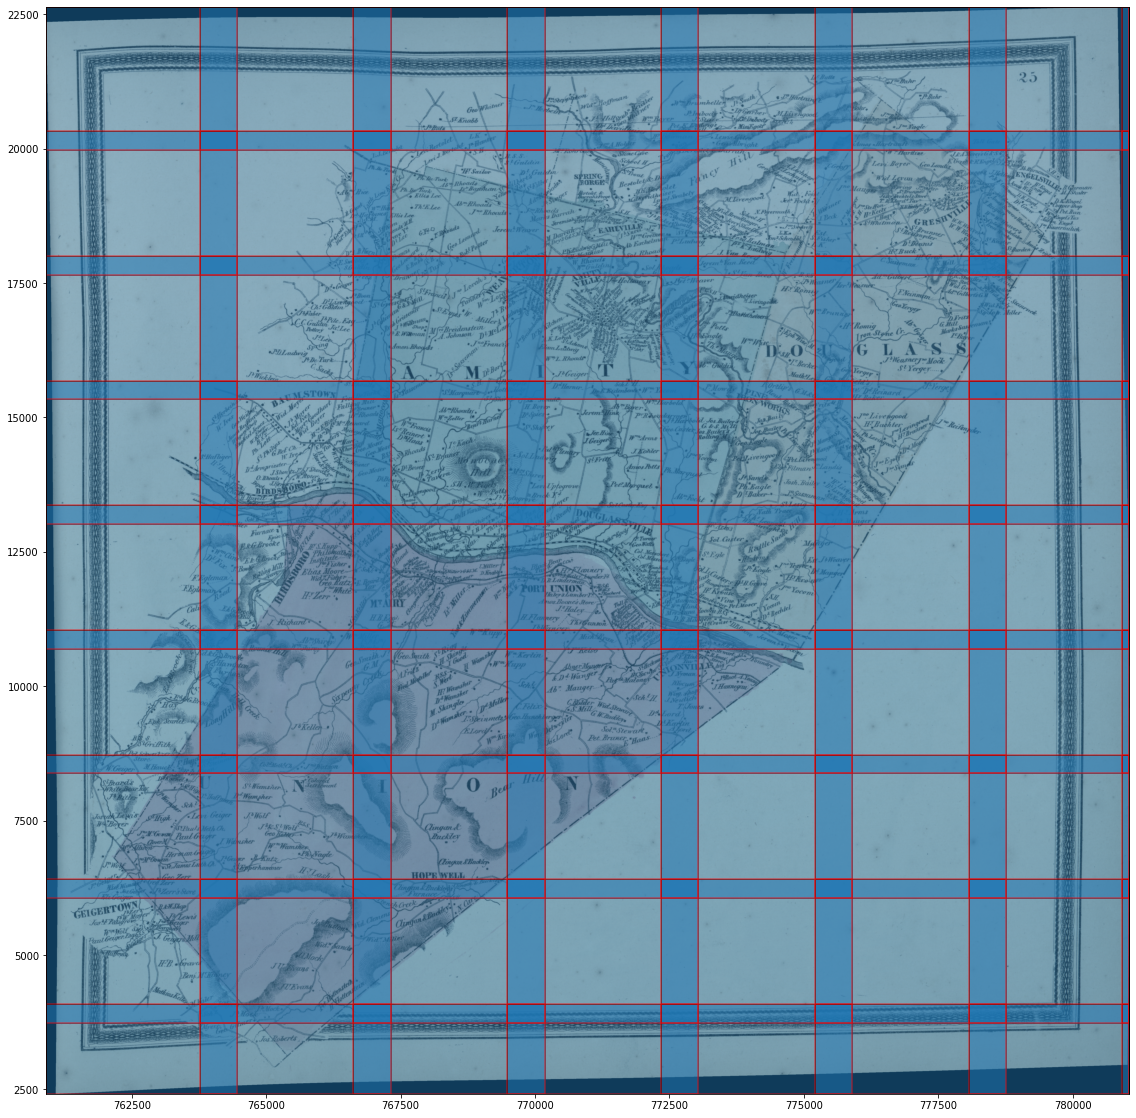

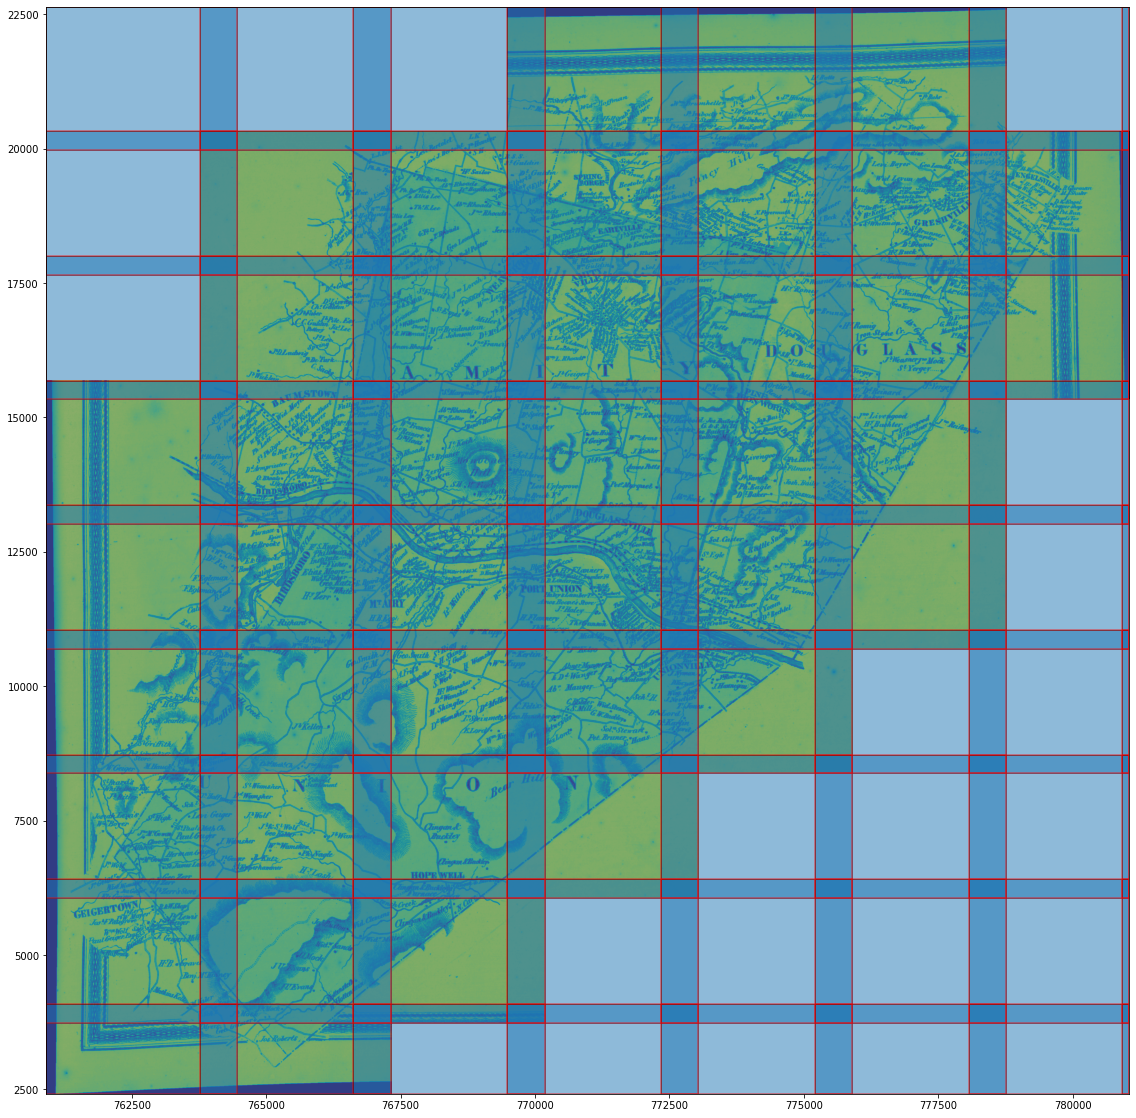

In [ ]:
tt = Tile_tiff('/content/drive/MyDrive/MaskCNNhearths/HopewellFurnace/UnionTshp_BerckCtyAtlas_1860_georef.tif',
               '/content/drive/MyDrive/MaskCNNhearths/HopewellFurnaceMapWork/tif_tiles')
print(tt.get_attributes())
print(tt.create_tile_matrix())
tt.create_tile_files()
#tt.plot_tif_and_poly()
tt.plot_tif_and_poly_map()

/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/nimadata1056734636.tif
{'cols': '5254', 'rows': '3477', 'crs': 'EPSG:4326', 'left_min_x': '36.5561111111', 'bottom_min_y': '36.35352120891358', 'right_max_x': '37.181230090730686', 'top_max_y': '36.6661111111', 'coords': '[(36.5561111111, 36.35352120891358), (37.181230090730686, 36.35352120891358), (37.181230090730686, 36.6661111111), (36.5561111111, 36.6661111111)]', 'pixel_size_x': '0.00011897963068722635', 'pixel_size_y': '8.990218642117377e-05'}
create_tile_matrix 6 5
[[[0, 0], [1024, 768], [0, 0]], [[1024, 0], [2048, 768], [1, 0]], [[2048, 0], [3072, 768], [2, 0]], [[3072, 0], [4096, 768], [3, 0]], [[4096, 0], [5120, 768], [4, 0]], [[5120, 0], [5254, 768], [5, 0]], [[0, 768], [1024, 1536], [0, 1]], [[1024, 768], [2048, 1536], [1, 1]], [[2048, 768], [3072, 1536], [2, 1]], [[3072, 768], [4096, 1536], [3, 1]], [[4096, 768], [5120, 1536], [4, 1]], [[5120, 768], [5254, 1536], [5, 1]], [[0, 1536], [1024, 2304], [0, 2]], [[

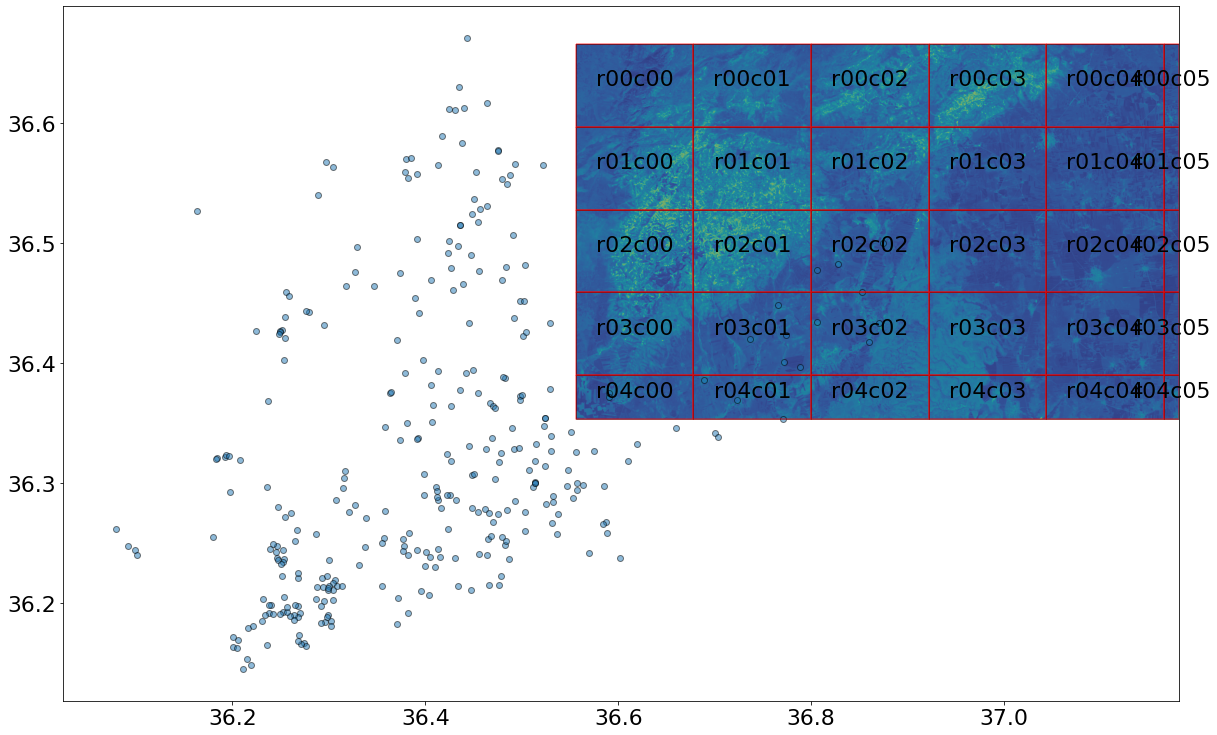

In [14]:
useful_tifs = []

useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/Amuq.tif') # pretty good 8 rows, 6 col
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/mosaic.tif') # pretty good 8 rows, 6 col
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/nimadata1056733980.tif') # off
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/nimadata1056734636.tif') # part of a mosaic
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/nimadata1056735482.tif')
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/nimadata1062871910.tif')
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/nimadata1062872704.tif')
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SPOT/SPOT Images/nimamosaic.tif') # 6 rows, 6 col
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/GDEM/Group 2/1020343_GDEM_N36E036_2011/1020343_GDEM_N36E036_2011_dem.tif') # a dem - does not look useful
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/GDEM/Group 2/1020343_GDEM_N36E036_2011/1020343_GDEM_N36E036_2011_num.tif') # does not look useful
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7k20000622_z37_nn61.tif') # off - no
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7k20000622_z37_nn62.tif') # off - no
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7p20000622_z37_nn80.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7t20000622_z37_nn10.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7t20000622_z37_nn20.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7t20000622_z37_nn30.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7t20000622_z37_nn40.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7t20000622_z37_nn50.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7t20000622_z37_nn70.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/epp174r035_7f20000622/p174r035_7f20000622_z37_ps742.tif') # no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/epp174r034_7f20000622/p174r034_7f20000622_z37_ps742.tif') # good
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/epp173r035_7f20000818/p173r035_7f20000818_z37_ps742.tif')# no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7t20000622_z37_nn50.tif')# no match
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7k20000622_z37_nn61.tif') # good
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7k20000622_z37_nn62.tif') #decent but not the best
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7p20000622_z37_nn80.tif') # huge tif, but maybe usable
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7t20000622_z37_nn10.tif') # huge tif 3 rows, 4 cols of points
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7t20000622_z37_nn20.tif') # large tif 3 rows, 4 cols of points
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7t20000622_z37_nn30.tif') # large tif 3 rows, 4 cols of points
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7t20000622_z37_nn40.tif') # large tif 3 rows, 4 cols of points
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r035_7t20000622/p174r035_7t20000622_z37_nn70.tif') # large tif 3 rows, 4 cols of points - not as good
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/epp175r034_7f20000613/p175r034_7f20000613_z36_ps742.tif') # no points on this one
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/epp175r035_7f20000613/p175r035_7f20000613_z36_ps742.tif') # almost no points
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/N-37-35_loc/N-37-35_loc.tif') # 2X 2 not useful
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/N-36-35_lr_2000/N-36-35_lr_2000.tif') # huge area - 3 x 4
useful_tifs.append('/content/drive/MyDrive/crane_ane/Satellite_Data/SRTM/n36_e036_3arc_v2.tif') # 2 tiles - does not look that good

# '/content/drive/MyDrive/crane_ane/Satellite_Data/LANDSAT/elp174r034_7t20000622/p174r034_7k20000622_z37_nn61.tif'
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
for ttf_cn in range(3,4):
    tff=useful_tifs[ttf_cn]
    print(tff)
    tt = Tile_tiff(tff,
               '/content/drive/MyDrive/crane_amuqall/data/images/')
    print(tt.get_attributes())
    print(tt.create_tile_matrix())
    tt.create_tile_files()
    #tt.plot_tif_and_poly()
    poly_df=gpd.read_file(os.path.join(tt.tt_tile_path,'tile_polys.shp'))
    ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
    rasterio.plot.show(tt.tt_raterio_dataset, ax=ax)
    poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
    amuqall_df=gpd.read_file("/content/drive/MyDrive/amuquall/data/amuqall.shp")
    amuqall_df = amuqall_df.to_crs(epsg=tt.tt_crs_int)
    amuqall_df.plot(ax=ax, alpha=0.5, edgecolor='k')

    poly_df['coords'] = poly_df['geometry'].apply(lambda x: x.representative_point().coords[:])
    poly_df['coords'] = [coords[0] for coords in poly_df['coords']]

    for idx, row in poly_df.iterrows():
        plt.annotate(s=row['id'], xy=row['coords'],                 horizontalalignment='center')


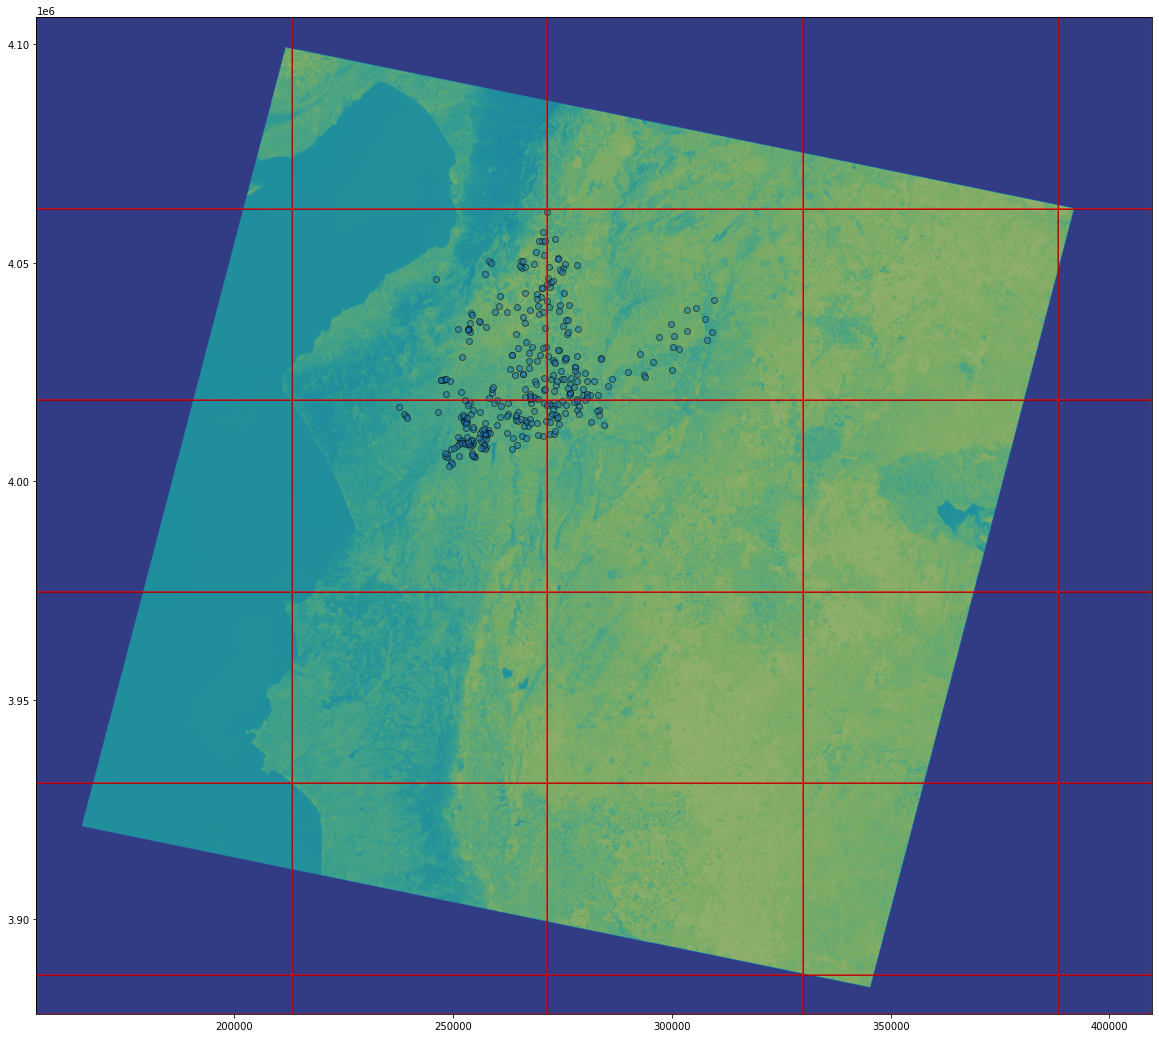

In [ ]:
poly_df=gpd.read_file(os.path.join(tt_tile_path,'tile_polys.shp'))
ax = poly_df.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
rasterio.plot.show(tt.tt_raterio_dataset, ax=ax)
poly_df.boundary.plot(ax=ax,color="red",alpha=0.5)
amuqall_df=gpd.read_file("/content/drive/MyDrive/amuquall/data/amuqall.shp")
amuqall_df = amuqall_df.to_crs(epsg=tt.tt_crs_int)
amuqall_df.plot(ax=ax, alpha=0.5, edgecolor='k')

In [8]:
print(poly_df)

           id                                           geometry
0   73.222222  POLYGON ((36.55611 36.66611, 36.67795 36.66611...
1   73.344057  POLYGON ((36.67795 36.66611, 36.79978 36.66611...
2   73.465893  POLYGON ((36.79978 36.66611, 36.92162 36.66611...
3   73.587728  POLYGON ((36.92162 36.66611, 37.04345 36.66611...
4   73.709563  POLYGON ((37.04345 36.66611, 37.16529 36.66611...
5   73.831398  POLYGON ((37.16529 36.66611, 37.18123 36.66611...
6   73.153177  POLYGON ((36.55611 36.59707, 36.67795 36.59707...
7   73.275012  POLYGON ((36.67795 36.59707, 36.79978 36.59707...
8   73.396848  POLYGON ((36.79978 36.59707, 36.92162 36.59707...
9   73.518683  POLYGON ((36.92162 36.59707, 37.04345 36.59707...
10  73.640518  POLYGON ((37.04345 36.59707, 37.16529 36.59707...
11  73.762353  POLYGON ((37.16529 36.59707, 37.18123 36.59707...
12  73.084132  POLYGON ((36.55611 36.52802, 36.67795 36.52802...
13  73.205968  POLYGON ((36.67795 36.52802, 36.79978 36.52802...
14  73.327803  POLYGON ((

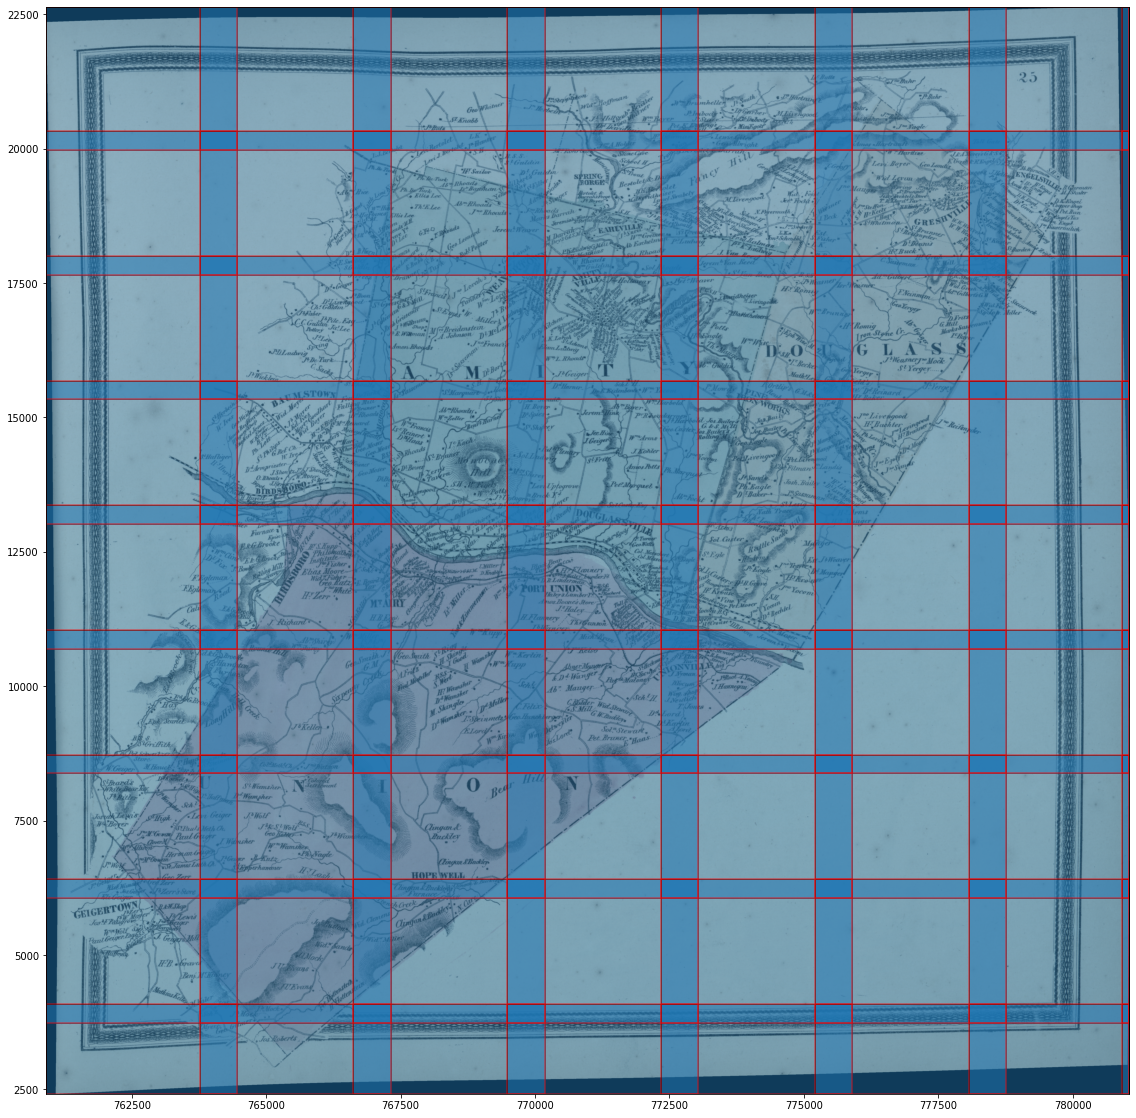

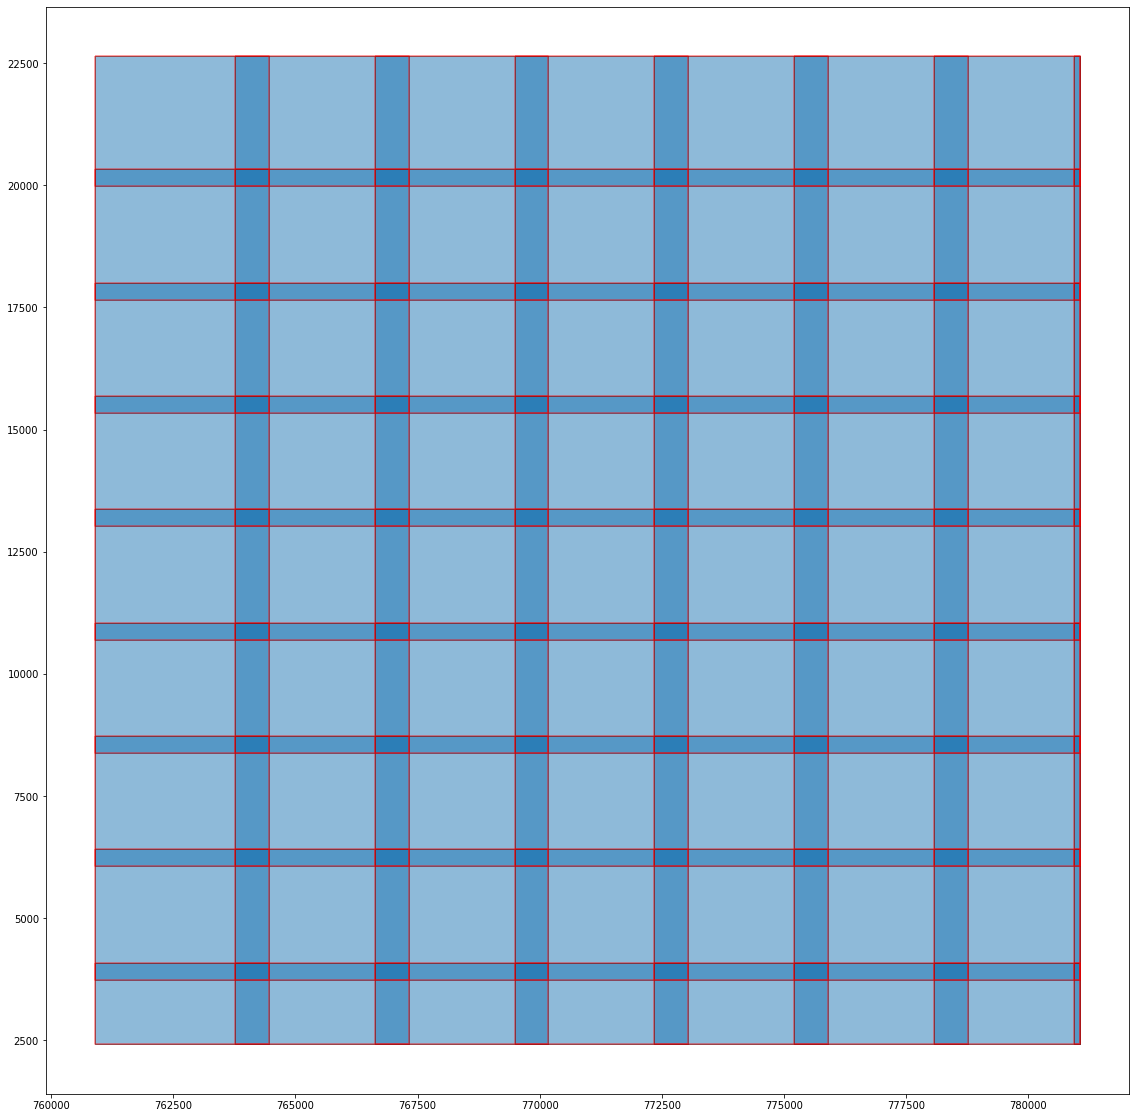

In [ ]:
tt.plot_tif_and_poly()

In [ ]:
import gdal
import rasterio

class Tile_tiff:

    # class attribute
    tiff_to_tile_path = ""

    # varables for gdal    
    tt_gdal_dataset = ""
    
    tt_cols = 0
    tt_rows = 0
    tt_transform = 0
    tt_minx = 0
    tt_maxx = 0
    tt_miny = 0
    tt_maxy = 0

    # varables for rasterio
    tt_raterio_dataset = 0
    tt_crs = 0
    tt_left = 0
    tt_bottom = 0
    tt_right = 0
    tt_top = 0
    tt_coords = 0
    tt_pixel_size_x = 0
    tt_pixel_size_y = 0

    def __init__(self,tiff_to_tile_path):
        self.tiff_to_tile_path = tiff_to_tile_path
        self.tt_gdal_dataset = gdal.Open(self.tiff_to_tile_path)
        self.tt_cols = self.tt_gdal_dataset.RasterXSize
        self.tt_rows = self.tt_gdal_dataset.RasterYSize
        self.tt_transform = self.tt_gdal_dataset.GetGeoTransform()
        self.tt_minx = self.tt_transform[0]
        self.tt_maxx = self.tt_transform[0] + self.tt_cols * self.tt_transform[1] + self.tt_rows * self.tt_transform[2]
        self.tt_miny = self.tt_transform[3] + self.tt_cols * self.tt_transform[4] + self.tt_rows * self.tt_transform[5]
        self.tt_maxy = self.tt_transform[3]
        

        self.tt_raterio_dataset = rasterio.open(self.tiff_to_tile_path)

        self.tt_crs =  self.tt_raterio_dataset.crs
        self.tt_left = self.tt_raterio_dataset.bounds[0]
        self.tt_bottom = self.tt_raterio_dataset.bounds[1]
        self.tt_right = self.tt_raterio_dataset.bounds[2]
        self.tt_top = self.tt_raterio_dataset.bounds[3]
        self.tt_coords = [(self.tt_left, self.tt_bottom), (self.tt_right, self.tt_bottom), (self.tt_right, self.tt_top), (self.tt_left, self.tt_top)]
    
        self.tt_pixel_size_x, self.tt_pixel_size_y = self.tt_raterio_dataset.res

    def get_attributes(self):
        return {
            "minX": str(self.tt_minx), 
            "maxX": str(self.tt_maxx),
            "minY": str(self.tt_miny), 
            "maxY": str(self.tt_maxy),
            "cols": str(self.tt_cols), 
            "rows": str(self.tt_rows),
            "crs": str(self.tt_crs),
            #"left": str(self.tt_left),
            #"bottom": str(self.tt_bottom),
            #"right": str(self.tt_right),
            #"top": str(self.tt_top),
            "coords": str(self.tt_coords),
            "pixel_size_x": str(self.tt_pixel_size_x),
            "pixel_size_y": str(self.tt_pixel_size_y)
            }

# instantiate the Parrot class
tt = Tile_tiff('/content/drive/MyDrive/MaskCNNhearths/HopewellFurnace/UnionTshp_BerckCtyAtlas_1860_georef.tif')
print(tt.get_attributes())


{'minX': '760899.8185612932', 'maxX': '781056.4684805449', 'minY': '2417.547719080616', 'maxY': '22643.643460620864', 'cols': '5805', 'rows': '5825', 'crs': 'EPSG:32128', 'left': '760899.8185612932', 'bottom': '2417.547719080616', 'right': '781056.4684805449', 'top': '22643.643460620864', 'coords': '[(760899.8185612932, 2417.547719080616), (781056.4684805449, 2417.547719080616), (781056.4684805449, 22643.643460620864), (760899.8185612932, 22643.643460620864)]', 'pixel_size_x': '3.4722911144275104', 'pixel_size_y': '3.4722911144275104'}


In [ ]:
"""
                if(lrx>self.tt_right_max_x):
                    lrx=self.tt_right_max_x
                if(lrx<self.tt_left_min_x):
                    lrx=self.tt_left_min_x
              
                if(lry>self.tt_top_max_y):
                    lry=self.tt_top_max_y
                if(lry<self.tt_bottom_min_y):
                    lry=self.tt_bottom_min_y

                if(ulx>self.tt_right_max_x):
                    ulx=self.tt_right_max_x
                if(ulx<self.tt_left_min_x):
                    ulx=self.tt_left_min_x

                if(uly>self.tt_top_max_y):
                    uly=self.tt_top_max_y
                if(uly<self.tt_bottom_min_y):
                    uly=self.tt_bottom_min_y
"""
                #print("matrix:",ulx, uly,lrx, lry)
                # tifcols starts from 0

{'minX': '760899.8185612932', 'maxX': '781056.4684805449', 'minY': '2417.547719080616', 'maxY': '22643.643460620864', 'cols': '5805', 'rows': '5825', 'crs': 'EPSG:32128', 'left': '760899.8185612932', 'bottom': '2417.547719080616', 'right': '781056.4684805449', 'top': '22643.643460620864', 'coords': '[(760899.8185612932, 2417.547719080616), (781056.4684805449, 2417.547719080616), (781056.4684805449, 22643.643460620864), (760899.8185612932, 22643.643460620864)]', 'pixel_size_x': '3.4722911144275104', 'pixel_size_y': '3.4722911144275104'}
